# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [217]:
import scipy
import random
import pandas as pd
import numpy as np
import threadpoolctl
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
import matplotlib.pyplot as plt

dir = "../dataset/utility"

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Load Dataset

In [218]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
items_df.index.value_counts()

ASIN
b001f30182    1
b08p59knm4    1
b08p4mbk17    1
b08mwqqhcd    1
b08lg9g3jt    1
             ..
b0bnqymlyq    1
b0bmv2c6lv    1
b0bmpzd2xs    1
b0bml7h9kq    1
b0ctcy1wtr    1
Name: count, Length: 33510, dtype: int64

In [ ]:
df_utility.columns.value_counts()

b001f30182    1
b08p59knm4    1
b08p4mbk17    1
b08mwqqhcd    1
b08lg9g3jt    1
             ..
b0bnqymlyq    1
b0bmv2c6lv    1
b0bmpzd2xs    1
b0bml7h9kq    1
b0ctcy1wtr    1
Name: count, Length: 33510, dtype: int64

In [ ]:
items_df

,level_0,toys,games,toy,figures,playsets,action,dolls,accessories,building,...,clogs,ballet,wedges,heeled,tights,shrugs,bras,workout,bottom,bodysuits
ASIN,,,,,,,,,,,,,,,,,,,,,
b001f30182,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b001gn794k,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00askv7fe,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00hzsmwmy,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00ik8qpoy,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b09n6xj3cl,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0cpffh4pz,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0clhh277z,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_utility

,b001f30182,b001gn794k,b00askv7fe,b00hzsmwmy,b00ik8qpoy,b00wo0adqk,b011miv3eu,b01jcuyul8,b07d8f6cn5,b07dfbjr78,...,b0cjv1mjxm,b0clswc33v,b0867bkglg,b0cj4gf1l4,b07ftsxdk4,b09n6xj3cl,b0cpffh4pz,b0clhh277z,b0brcjl4mm,b0ctcy1wtr
reviewerID,,,,,,,,,,,,,,,,,,,,,
***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A._,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJ_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dac_AHK2DUBBBFRGDSNKJG6CQA7AT3OA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mike_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
reviews_df

,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
TK-815TK-815_AH4NM3KGMDME7SKRSJD73TIBABIQ,0,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"September 21, 2022",United States,13
vyeranos_AESWEZHPRRYTZRW2FBIJSXEKGTFA,1,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"January 13, 2024",United States,0
Marty_AHGIPPEB6HKSXNPB6Y3DLBKCVRHQ,2,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"November 24, 2023",United States,0
Kati_AHWQ73WR7MVGBKDB5YE6C4WDPNJA,3,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"January 2, 2024",United States,0
Lochlan LongstriderLochlan Longstrider_AHSHUIZHSPWYY3OD3PI56MSBKZ4Q,4,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,4.0,"September 18, 2023",United States,0
...,...,...,...,...,...,...,...
Amazon CustomerAmazon Customer_AG52QM7OQDTBA4PS7FE4YBCXSOWA,325335,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,4.0,"February 4, 2024",United States,0
Jenny Woods_AEO3O5NXXEBNIGTFD2NYQBH6V4JA,325336,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,4.0,"February 10, 2024",United States,0
Reviews!Reviews!_AGBE2PKD6HCB7S4I4FWGQDLM626A,325337,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,5.0,"February 6, 2024",United States,0


In [ ]:
asins_df

,name
ASIN,
b001f30182,STAR WARS The Black Series Dark Trooper Toy 6-...
b001gn794k,"Avatar: The Last Airbender Prince Zuko 7"" Acti..."
b00askv7fe,Hasbro Marvel Ultimate Spider-man Titan Hero S...
b00hzsmwmy,Accoutrements Crazy Cat Lady Action Figure Mul...
b00ik8qpoy,Marvel Ultimate Spider-Man Titan Hero Series A...
...,...
b07zt8vlv4,Bestisun Womens Long Sleeve Workout Tops Yoga ...
b0cqy9mrmr,Maxbee Flared Leggings with Pockets for Women ...
b0cjr8rplq,"TownCat Women’s Yoga Pants with Pockets, High ..."


# Try all algorithms
* Neighborhood-based collaborative filtering
* Latent-factor based collaborative filtering
* Content-based collaborative filtering

## Neighborhood-based Collaborative Filtering

From Surprise

In [ ]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(), KNNWithMeans(), SVD()]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


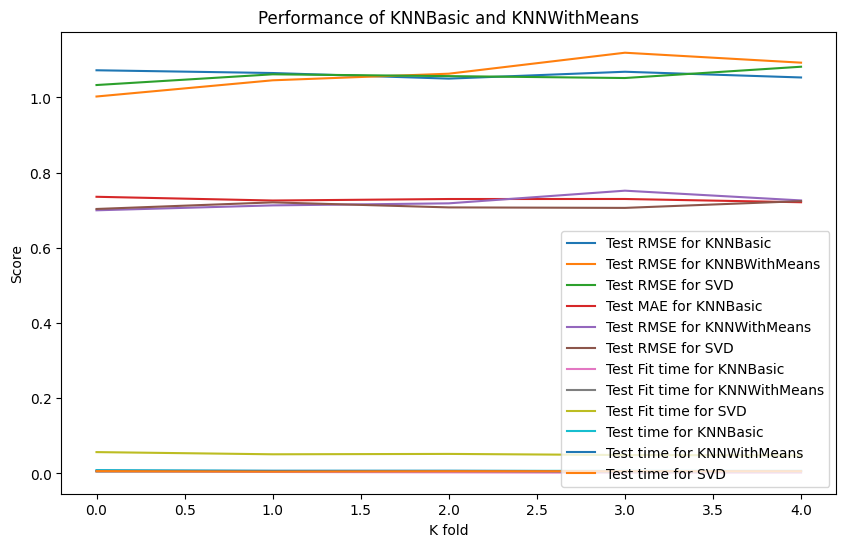

In [ ]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)


k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

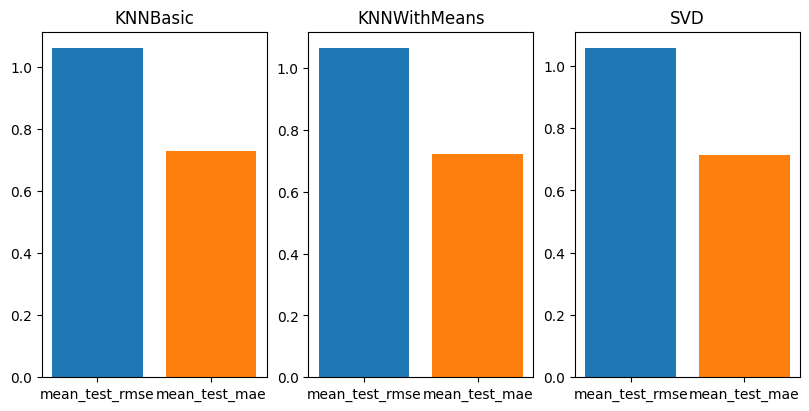

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    print(f"computing precision and recall for {algo}")
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)

computing precision and recall for <surprise.prediction_algorithms.knns.KNNBasic object at 0x00000233E675F750>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x0000023404D3E290>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise

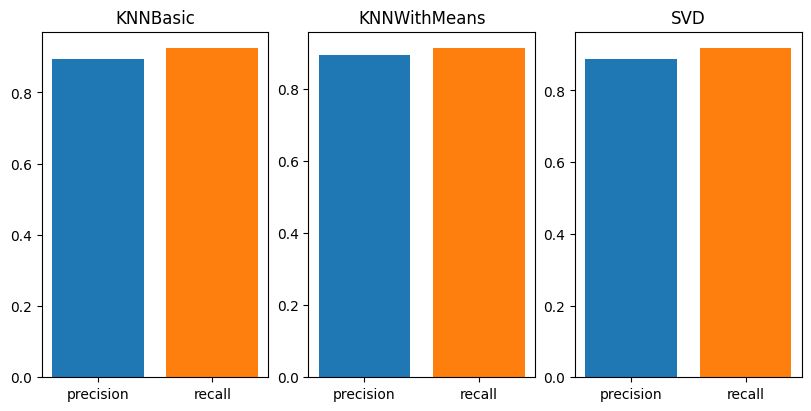

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations for a user

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset)
top_n = get_top_n(predictions, n=10)
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

Use SVD because KNN sucks

In [ ]:
def show_user_history_and_recos(recommendations, user_id):
    """
    Display user purchase history and recommendations
    """
    display(reviews_df.loc[[user_id]][['ProductName', 'reviewRating']])
    reco_list = recommendations[user_id]
    print("recommended items")
    display(asins_df.loc[reco_list])
    print('\n')

In [ ]:
userids = [x for x in list(recommendations.keys()) if len(x.split('_')[-1]) > 1][:5]
for user_id in userids:
    show_user_history_and_recos(recommendations, user_id)

,ProductName,reviewRating
reviewerID,,
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,famiworths_upgraded_hot_and_iced_coffee_maker_...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,cros_60_loads_laundry_detergent_sheets_linen_s...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,"oak_wooden_decorative_kitchen_tray_112""l_dish_...",5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,vanity_mirror_with_lights9_led_bulbs_hollywood...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,air_fryer_toaster_oven_combo__fabuletta_18in1_...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,huijutchen_mini_printer_portable_bluetooth_poc...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,[electric_focus]_5g_wifi_mini_bluetooth_projec...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,antitheft_ring_doorbell_door_mount__no_drill_c...,5.0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,steamer_for_clothes_portable_handheld_garment_...,5.0


recommended items


,name
ASIN,
b00u1s453e,The Post-Human Omnibus: Books 1-4
b00c5394io,A-Tech 8GB (2x4GB) DDR3 1333MHz PC3-10600 CL9 ...
b097bx4wgs,Amazon Essentials Women's Short-Sleeve Scoop N...
b0bkq7my3l,"Gaiatop Portable Clip on Fan Battery Operated,..."
b09mcvc7cq,"Hot and Cold Bidet Attachment for Toilet, Ultr..."
b0bl2ztym1,Extra Long 26.2ft Cord 18V500mA Doorbell Trans...
b0crrxfqt9,The Mad Duke Takes a Bride: A Historical Regen...
b08gssy4j4,Corsair Vengeance RGB Pro 64GB (4x16GB) DDR4 3...
b0cpj7cq88,FNTCASE for Samsung Galaxy S24-Plus Case: Clea...


,ProductName,reviewRating
reviewerID,,
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,amazon_basics_36pack_aaa_alkaline_highperforma...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,duracell_2032_lithium_battery_6_count_pack_chi...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,lavemi_mens_belt_stretch_elastic_casual_woven_...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,ultra_clarity_cables_cat6_ethernet_cable_10_ft...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,men_original_protection_antiperspirant_deodora...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,amazon_basics_dishwasher_detergent_pacs_fresh_...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,cetaphil_face_wash_daily_facial_cleanser_for_s...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,neosporin_+_lidocaine_first_aid_antibiotic_oin...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,apple_airtag,5.0


recommended items


,name
ASIN,
b096myb1h1,Dell SE2722HX Monitor - 27 inch FHD (1920 x 10...
b0839bfr5y,Seventh Generation Concentrated Laundry Deterg...
b08cly6nmn,TEAMGROUP T-Force Delta RGB DDR4 32GB (2x16GB)...
b07vk3y6f8,ESR Air Armor Series Compatible with iPhone 11...
b0b47hlq5b,Carlisle FoodService Products Mop Bucket with ...
b01dfai4u4,LACTACYD FEMINA Intimate Washing Lotion 200ML ...
b08sk4yznd,EVOOMI Back Saver Monitor Stand for Desk - 2 P...
b002nkn9r6,"Nuby Medi-Nurser Medicine Bottle, Colors May Vary"
b0bhsbzmpg,"Anti-Theft Video Doorbell Mount, No-Drill Moun..."


,ProductName,reviewRating
reviewerID,,
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,"greenvelly_steel_snapit_storage_cabinet_72""_lo...",5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,64gb_hidden_camera_spy_camera_full_hd_1080p_na...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,vamcheer_washable_abstract_area_rug__contempor...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,vamcheer_washable_abstract_area_rug__contempor...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,dresser_for_bedroom_modern_white_dresser_with_...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,mini_first_aid_kit__120_piece_small_waterproof...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,industrial_small_table_lampmodern_metal_bedsid...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,vooii_compatible_with_iphone_13_case_liquid_si...,5.0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,charmp_portable_handheld_fan_small_personal_fa...,5.0


recommended items


,name
ASIN,
b01fyd9sku,"Transcend 120 GB TLC SATA III 6Gb/s 2.5"" Solid..."
b07vk3y6f8,ESR Air Armor Series Compatible with iPhone 11...
b07k12fs2r,Chicco Bravo For2 Standing/Sitting Double Stro...
b07k4dlmjz,Where the Forest Meets the Stars
b0bkb5bjdc,"DIBBATU Disposable Urinal Bag, 12/24 Pcs 800ML..."
b0crrxfqt9,The Mad Duke Takes a Bride: A Historical Regen...
b000yk48ea,Gillette Venus Satin Care Shaving Gel Sensitiv...
b08yp9jrhp,LEGO DUPLO My First Number Train Toy with Bric...
b0bpwy9nb8,Caseative Water Ripple Pattern Curly Wave Fram...


,ProductName,reviewRating
reviewerID,,
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,gunsmoke_and_danger:_a_historical_western_adve...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,wrath_of_the_lone_rider:_a_historical_western_...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,riders_of_the_mountains:_a_historical_western_...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,outlaw_on_the_ranch:_a_historical_western_adve...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,grit_and_gunpowder:_a_historical_western_adven...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,a_detective's_bloody_pursuit:_a_historical_wes...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,thunder_on_the_chisholm_trail:_a_historical_we...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,a_hunter's_unseen_shadow:_a_historical_western...,5.0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,ambush_in_the_dusty_mines:_a_historical_wester...,5.0


recommended items


,name
ASIN,
b0839bfr5y,Seventh Generation Concentrated Laundry Deterg...
b08br4351s,"HOOBRO 8-Tier Shoe Rack Organizer, Large Capac..."
b087jh5c7f,Krisler Adjustable Threaded Bed Frame Anti-Sha...
b01dfai4u4,LACTACYD FEMINA Intimate Washing Lotion 200ML ...
b005kvgfrq,"Grab Green 3-in-1 Laundry Detergent Pods, 60 C..."
b0b69b289d,"Small Side Table for Living Room, Modern Home ..."
b09jnmy6bm,MooMee Bedding Duvet Cover Set 100% Washed Cot...
b002nkn9r6,"Nuby Medi-Nurser Medicine Bottle, Colors May Vary"
b0ctsq8mbq,ALDO Legoiri


,ProductName,reviewRating
reviewerID,,
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,2_pack_air_purifiers_for_bedroom5_layers_h13_h...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,boys_girls_toys_age_45little_boy_magnetic_bloc...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,4k_waterproof_digital_camera_11ft_underwater_c...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,wireless_keyboard_and_mouse_combo_compact_quie...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,knife_sets_for_kitchen_with_block_hunterdual_1...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,pop_voice_microphone_professional_for_iphone_l...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,proar_microphone_for_podcast_usb_microphone_ki...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,moukabal_over_the_sink_dish_drying_rack_with_2...,5.0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,ymhml_[3+3]_3_pack_iphone_14_pro_screen_protec...,5.0


recommended items


,name
ASIN,
b0bcdr9m33,Intel Core i5-13600K Desktop Processor 14 (6 P...
b087jh5c7f,Krisler Adjustable Threaded Bed Frame Anti-Sha...
b0ctsq8mbq,ALDO Legoiri
b094xfg8x9,"AGPTEK Smart Watch, 1.69""(43mm) Smartwatch for..."
1441332693,"Smiley Face Note Cards (Stationery, Boxed Cards)"
b0clb8k2zj,KAFRI RGB Headphone Stand with USB Hub Desk Ga...
b07k12fs2r,Chicco Bravo For2 Standing/Sitting Double Stro...
b0crqn816h,A Wallflower for the Stoic Duke: A Historical ...
b00u1s453e,The Post-Human Omnibus: Books 1-4


## Latent-factor based Collaborative Filtering

### ALS

'export' is not recognized as an internal or external command,
operable program or batch file.
100%|██████████| 394/394 [00:00<00:00, 4986.21it/s]


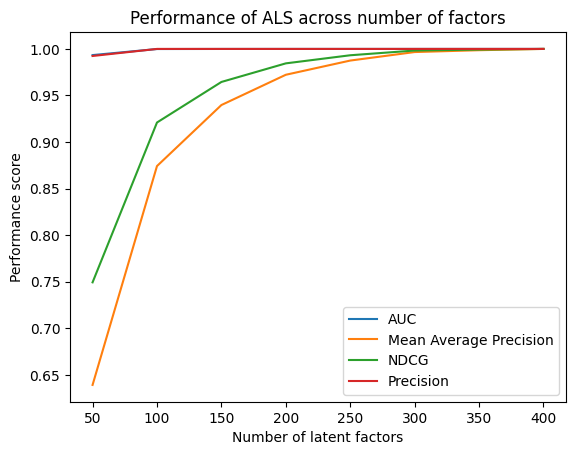

In [ ]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350, 400]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.1,
        alpha=1,
        calculate_training_loss=True,
        use_cg=True,
        iterations=30,
        random_state=143
    )
    model.fit(csr_utility)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

In [ ]:
model = ALS(
    factors=300,
    regularization=0.1,
    alpha=1,
    calculate_training_loss=True,
    use_cg=True,
    iterations=30,
    random_state=143
)
model.fit(csr_utility)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  8.52it/s, loss=0.000172]


In [ ]:
def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs
userids_ilocs = get_ilocs(df_utility, userids)

In [ ]:
ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        print(f"user history: {reviewer_id}")
        display(reviews_df.loc[reviewer_id])
        print("recommendations")
        inds = df_utility.columns[reco_ids]
        display(asins_df.loc[inds])
        
show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility)

user history: Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,56452,b0cq286f6p,famiworths_upgraded_hot_and_iced_coffee_maker_...,5.0,"January 12, 2024",United States,21
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,78764,b0cl41z1hd,cros_60_loads_laundry_detergent_sheets_linen_s...,5.0,"December 4, 2023",United States,2
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,80915,b0cg5y9d7l,"oak_wooden_decorative_kitchen_tray_112""l_dish_...",5.0,"November 14, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,168667,b0b63gxzrs,vanity_mirror_with_lights9_led_bulbs_hollywood...,5.0,"August 25, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,194581,b09h7fnbc1,air_fryer_toaster_oven_combo__fabuletta_18in1_...,5.0,"June 23, 2023",United States,43
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,216672,b0by8sjv6h,huijutchen_mini_printer_portable_bluetooth_poc...,5.0,"June 14, 2023",United States,7
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,218115,b0c5cyrq1s,[electric_focus]_5g_wifi_mini_bluetooth_projec...,5.0,"August 2, 2023",United States,5
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,224546,b0cl1fzxnb,antitheft_ring_doorbell_door_mount__no_drill_c...,5.0,"November 23, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,255730,b0ckpgm6yk,steamer_for_clothes_portable_handheld_garment_...,5.0,"December 5, 2023",United States,5


recommendations


,name
b0bwj77ndw,"DeerValley DV-1F52102 Ace One Piece Toilet, Du..."
b0c3cnxn9w,USB 3.0 Flash Drive KOOTION 10 Pack 32GB USB 3...
b09ygdxvvy,KOOTION 128 GB USB 3.0 Flash Drive Thumb Drive...
b0ck6qrx79,EKIFT Ease Now Cervical Neck Pillow for Pain R...
b0b74165p5,"Wireless Keyboard Mouse Combo, EDJO 2.4G Full-..."
b0cq7p7ljl,"GPS Navigator for Car, Latest 2024 Map 7 inch ..."
b0813bwkww,7 Inch Touch Screen GPS Navigation System for ...
b09vj779xq,Acne Clarifying Face Toner for Teens by Natura...
b0bmm8f4hq,"RAVMAG Rubber Broom Lightweight, 100% Natural ..."
b0cmcqxs15,Electric Baby Bottle Cleaner Kit with Recharge...


user history: Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,17056,b00lh3dmuo,amazon_basics_36pack_aaa_alkaline_highperforma...,5.0,"January 20, 2024",United States,4
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,17956,b0855fd9p2,duracell_2032_lithium_battery_6_count_pack_chi...,5.0,"January 20, 2024",United States,6
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,25275,b0cq76fstr,lavemi_mens_belt_stretch_elastic_casual_woven_...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,35181,b07ftsfgxh,ultra_clarity_cables_cat6_ethernet_cable_10_ft...,5.0,"January 21, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,70030,b001et769y,men_original_protection_antiperspirant_deodora...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,82354,b09clr75k6,amazon_basics_dishwasher_detergent_pacs_fresh_...,5.0,"January 20, 2024",United States,9
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,95277,b099mszx25,cetaphil_face_wash_daily_facial_cleanser_for_s...,5.0,"January 23, 2024",United States,5
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,103797,b0bqksh6qc,neosporin_+_lidocaine_first_aid_antibiotic_oin...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,110754,b0933bvk6t,apple_airtag,5.0,"January 23, 2024",United States,2


recommendations


,name
b0069lvjuy,Monoprice Low Profile 7.5 lb. Capacity Speaker...
b07hc7p3hj,"ARCTIC P12 (5 Pack) - 120 mm Case Fan, Pressur..."
b06xckgltp,"FIFINE USB Microphone, Metal Condenser Recordi..."
b0bzwzsm7d,Steve Madden Men's Dress Casual Every Day Leat...
b0bxq5rdwb,LEGO NINJAGO Lloyd’s Dragon Power Spinjitzu Sp...
b0csb3lrkw,Observer: A Novel
b0bvdvxp4n,"2 PCS 5 Layers Baby Milk Powder Dispenser, Mil..."
b097gxm3hg,Topfeel Professional Chef Knife Set Sharp Knif...
b0c2ypvsfx,General Medi 110 Pieces Small First Aid Kit - ...
b0cpxj3jcg,Stranded: A Dark Romance Novella


user history: Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,33218,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_lo...",5.0,"November 1, 2023",United States,3
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,37093,b0cmxfzml5,64gb_hidden_camera_spy_camera_full_hd_1080p_na...,5.0,"January 22, 2024",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,43877,b0bs8hb9sf,vamcheer_washable_abstract_area_rug__contempor...,5.0,"November 17, 2023",United States,4
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,43885,b0bs8v2s7n,vamcheer_washable_abstract_area_rug__contempor...,5.0,"November 17, 2023",United States,4
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,86331,b0c5rtvl4b,dresser_for_bedroom_modern_white_dresser_with_...,5.0,"July 31, 2023",United States,6
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,103869,b0c3dkc7xf,mini_first_aid_kit__120_piece_small_waterproof...,5.0,"August 5, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,137701,b0ccjr1zbl,industrial_small_table_lampmodern_metal_bedsid...,5.0,"September 30, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,210322,b0ckt5c13j,vooii_compatible_with_iphone_13_case_liquid_si...,5.0,"December 10, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,215113,b0c3dc9y3m,charmp_portable_handheld_fan_small_personal_fa...,5.0,"August 4, 2023",United States,0


recommendations


,name
b0cbbxlfwn,High Waisted Leggings for Women Workout Gym Tu...
b0bpgqv3x5,Women's Leather Loafers Classic Penny Loafers ...
b0c4h1y8bc,"BY4U Steamer for Clothes, Portable Handheld Ga..."
b0cffcmsd2,"Ergonomic Office Chair, Home Office Desk Chair..."
b0c2yrd63h,Newspin Queen Bed in a Bag 8 Pieces Comforter ...
b0c7c1qcym,"Reyee AX3000 Wi-Fi 6 Router, Dual Band Interne..."
b0c4gzn99v,"Steamer for Clothes, Portable Handheld Garment..."
b07bkwcyw6,"SADES V2020 Keyboard and Mouse Combo, Colorful..."
b0bgn7j4jd,64GB Hidden Camera DIY 1080P Mini Portable Spy...
b0bwdy1btw,TOSCiDO Tablet 2023 Android 12 Tablets 10.3 in...


user history: Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4339,b0bydvf248,gunsmoke_and_danger:_a_historical_western_adve...,5.0,"March 23, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4410,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_...,5.0,"July 9, 2023",United States,2
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4489,b0cg6qx78p,riders_of_the_mountains:_a_historical_western_...,5.0,"August 30, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4512,b0cjxqt4gs,outlaw_on_the_ranch:_a_historical_western_adve...,5.0,"October 6, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4557,b0cntp5wdn,grit_and_gunpowder:_a_historical_western_adven...,5.0,"December 2, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4569,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_wes...,5.0,"December 9, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4578,b0cqcxc9n3,thunder_on_the_chisholm_trail:_a_historical_we...,5.0,"December 23, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4585,b0cqjhv821,a_hunter's_unseen_shadow:_a_historical_western...,5.0,"December 26, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4623,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_wester...,5.0,"January 8, 2024",United States,0


recommendations


,name
b0cs3jr3vh,Gunsmoke in Silver City: A Historical Western ...
b0crpg6g5n,Finding Love's Sanctuary: A Historical Western...
b0cs6sdm6x,Forbidden Love and Thunder: A Historical Weste...
b0ctcy38sv,The Icy Duke Claims a Bride: A Historical Rege...
b0ctcv6lck,Rescuing the Kidnapped Heiress: A Historical W...
b0cs9wm3cw,Ravished by the Duke of Sin: A Historical Rege...
b0ct3t4qzf,Her Mysterious Duke: A Historical Regency Roma...
b0csdn6975,Blossoming into a Lady: A Historical Regency R...
b0csszcxzf,Loving a Healer in Disguise: A Historical West...
b0cszdxzx6,My Cruel Duke: A Steamy Marriage of Convenienc...


user history: Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,9777,b0bwxlmnyk,2_pack_air_purifiers_for_bedroom5_layers_h13_h...,5.0,"November 1, 2022",United States,12
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,31307,b09h7mzj49,boys_girls_toys_age_45little_boy_magnetic_bloc...,5.0,"September 16, 2022",United States,9
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,37061,b0c61qswh6,4k_waterproof_digital_camera_11ft_underwater_c...,5.0,"October 18, 2022",United States,8
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,131836,b0b7sjzt7r,wireless_keyboard_and_mouse_combo_compact_quie...,5.0,"October 12, 2022",United States,0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,132929,b09z65mvy5,knife_sets_for_kitchen_with_block_hunterdual_1...,5.0,"August 26, 2022",United States,16
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,164352,b098q2h7p6,pop_voice_microphone_professional_for_iphone_l...,5.0,"June 15, 2022",United States,8
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,164385,b09d38565s,proar_microphone_for_podcast_usb_microphone_ki...,5.0,"February 22, 2022",United States,15
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,196237,b09pg9l36w,moukabal_over_the_sink_dish_drying_rack_with_2...,5.0,"July 18, 2022",United States,0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,233225,b0b7jyyrfd,ymhml_[3+3]_3_pack_iphone_14_pro_screen_protec...,5.0,"October 19, 2022",United States,4


recommendations


,name
b0b62ptd5j,Digital Baby Camera for Kids Teens Boys Girls ...
b0cn6k27d2,Women's Seamless Cheeky Panties No-Show Bikini...
b0bwdy1btw,TOSCiDO Tablet 2023 Android 12 Tablets 10.3 in...
b0bj612lkb,"CARPETNAL White Dresser, Modern Dresser for Be..."
b0c7l47h1s,"Laundry Detergent Sheets by Enyur, Laundry She..."
b09sz8qgyz,Soft Area Rug for Bedroom Living Room Furry Bi...
b09sz8b6q3,6X9 Soft Area Rug for Bedroom Living Room Furr...
b0cnpbp39m,KAEILORU Magnetic Tiles Magnetic Building Bloc...
b0bd8k2hrb,"Magnetic Blocks,1.42inch Large Magnetic Buildi..."
b07bkwcyw6,"SADES V2020 Keyboard and Mouse Combo, Colorful..."


## Content-based

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

### Basic Content-Based Recommender

In [253]:
def get_user_profile(reviewerID, df_utility, items_df):
    user_ratings = df_utility.loc[reviewerID]
    user_ratings_nonnan = user_ratings[user_ratings.notnull()]
    mean = np.mean(user_ratings_nonnan)
    mean_centered_user_ratings = user_ratings_nonnan - mean
    nonnan_asins = mean_centered_user_ratings.index.tolist()
    dotprod = np.dot(mean_centered_user_ratings, items_df.loc[nonnan_asins])
    return dotprod


def get_recommendations(user_profile, items_df,
                        n, user_history, eval):
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(distance.euclidean(feats, user_profile))
        if eval and ind in user_history:
            similarities[ind] = np.abs(distance.euclidean(feats, user_profile))
    return dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=False)[:n])


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, asins_df, n, eval):
    recommendations = {}
    for user in userids:
        user_profile = get_user_profile(user, df_utility, items_df)
        recos = get_recommendations(
            user_profile,
            items_df,
            n,
            reviews_df.loc[user]['ASIN'].tolist(),
            eval
        )
        recommendations[user] = recos
        print(f"user history: {user}")
        display(reviews_df.loc[user])
        print(f"recommended items")
        display(asins_df.loc[list(recos.keys())])
        print(f"scores")
        print(recommendations)
    return recommendations
        
def get_rmse(df_utility, items_df,
    reviews_df, asins_df):
    userids = df_utility.index.tolist()
    recommendations = basic_content_based_recommender(
        userids, df_utility, items_df,
        reviews_df, asins_df, len(items_df), True)
    return recommendations


In [254]:
try:
    items_df.drop('level_0', inplace=True, axis=1)
except:
    pass
items_df.fillna(0, inplace=True)
df_utility.fillna(0, inplace=True)
recommendations = basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, asins_df, 10, False)

user history: Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,56452,b0cq286f6p,famiworths_upgraded_hot_and_iced_coffee_maker_...,5.0,"January 12, 2024",United States,21
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,78764,b0cl41z1hd,cros_60_loads_laundry_detergent_sheets_linen_s...,5.0,"December 4, 2023",United States,2
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,80915,b0cg5y9d7l,"oak_wooden_decorative_kitchen_tray_112""l_dish_...",5.0,"November 14, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,168667,b0b63gxzrs,vanity_mirror_with_lights9_led_bulbs_hollywood...,5.0,"August 25, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,194581,b09h7fnbc1,air_fryer_toaster_oven_combo__fabuletta_18in1_...,5.0,"June 23, 2023",United States,43
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,216672,b0by8sjv6h,huijutchen_mini_printer_portable_bluetooth_poc...,5.0,"June 14, 2023",United States,7
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,218115,b0c5cyrq1s,[electric_focus]_5g_wifi_mini_bluetooth_projec...,5.0,"August 2, 2023",United States,5
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,224546,b0cl1fzxnb,antitheft_ring_doorbell_door_mount__no_drill_c...,5.0,"November 23, 2023",United States,0
Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,255730,b0ckpgm6yk,steamer_for_clothes_portable_handheld_garment_...,5.0,"December 5, 2023",United States,5


recommended items


,name
ASIN,
b08573dq39,"Umite Chef Kitchen Cooking Utensils Set, 33 pc..."
b00ktwwc0u,"Cuisinart Barrel Crock Set, Set of 6, Steel"
b075mdq977,Home Hero 25 Pcs Kitchen Utensils Set - Stainl...
b077bg4t9c,Home Hero 54 Pcs Stainless Steel Kitchen Utens...
b07g2m4wq5,Kitchen Utensils Set 35 PCS Cooking Utensils S...
b082b9ssm5,"Silicone Cooking Utensil Set, Umite Chef 15pcs..."
b084jlm61c,Zulay Kitchen 14.8 Inch Premium Wok Spatula St...
b0872j1c4v,Silicone Kitchen Utensils Set & Holder: Cookin...
b088dgbrmc,Silicone Cooking Utensils Set - 446°F Heat Res...


scores
{'Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b08573dq39': 54.53622572938286, 'b00ktwwc0u': 54.53622572938286, 'b075mdq977': 54.53622572938286, 'b077bg4t9c': 54.53622572938286, 'b07g2m4wq5': 54.53622572938286, 'b082b9ssm5': 54.53622572938286, 'b084jlm61c': 54.53622572938286, 'b0872j1c4v': 54.53622572938286, 'b088dgbrmc': 54.53622572938286, 'b0892zxbmn': 54.53622572938286}}
user history: Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,17056,b00lh3dmuo,amazon_basics_36pack_aaa_alkaline_highperforma...,5.0,"January 20, 2024",United States,4
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,17956,b0855fd9p2,duracell_2032_lithium_battery_6_count_pack_chi...,5.0,"January 20, 2024",United States,6
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,25275,b0cq76fstr,lavemi_mens_belt_stretch_elastic_casual_woven_...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,35181,b07ftsfgxh,ultra_clarity_cables_cat6_ethernet_cable_10_ft...,5.0,"January 21, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,70030,b001et769y,men_original_protection_antiperspirant_deodora...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,82354,b09clr75k6,amazon_basics_dishwasher_detergent_pacs_fresh_...,5.0,"January 20, 2024",United States,9
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,95277,b099mszx25,cetaphil_face_wash_daily_facial_cleanser_for_s...,5.0,"January 23, 2024",United States,5
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,103797,b0bqksh6qc,neosporin_+_lidocaine_first_aid_antibiotic_oin...,5.0,"January 20, 2024",United States,0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,110754,b0933bvk6t,apple_airtag,5.0,"January 23, 2024",United States,2


recommended items


,name
ASIN,
b074x1g81c,ACASIS 80GB Ultra Slim Portable External Hard ...
b007jgb0ei,Apricorn 1TB Aegis Padlock USB 3.0 256-bit AES...
b0797fythz,Avolusion 1TB USB 3.0 Portable External Gaming...
b0797ksj7f,Avolusion 500GB USB 3.0 Portable External Hard...
b087pxf8nc,Avolusion HD250U3 2TB USB 3.0 Portable Externa...
b09x8lnvsy,Avolusion HD250U3-WH 1TB USB 3.0 Portable Exte...
b099dcxnpy,Avolusion HD250U3-Z1-PRO 1TB USB 3.0 Portable ...
b099dd72lk,Avolusion HD250U3-Z1-PRO 2TB USB 3.0 Portable ...
b09lqhmwbx,Avolusion HD250U3-Z1-PRO-WH 1TB USB 3.0 Portab...


scores
{'Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b08573dq39': 54.53622572938286, 'b00ktwwc0u': 54.53622572938286, 'b075mdq977': 54.53622572938286, 'b077bg4t9c': 54.53622572938286, 'b07g2m4wq5': 54.53622572938286, 'b082b9ssm5': 54.53622572938286, 'b084jlm61c': 54.53622572938286, 'b0872j1c4v': 54.53622572938286, 'b088dgbrmc': 54.53622572938286, 'b0892zxbmn': 54.53622572938286}, 'Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ': {'b074x1g81c': 112.59881454751435, 'b007jgb0ei': 112.59881454751435, 'b0797fythz': 112.59881454751435, 'b0797ksj7f': 112.59881454751435, 'b087pxf8nc': 112.59881454751435, 'b09x8lnvsy': 112.59881454751435, 'b099dcxnpy': 112.59881454751435, 'b099dd72lk': 112.59881454751435, 'b09lqhmwbx': 112.59881454751435, 'b074qm663j': 112.59881454751435}}
user history: Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A


,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,33218,b088ndkcrz,"greenvelly_steel_snapit_storage_cabinet_72""_lo...",5.0,"November 1, 2023",United States,3
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,37093,b0cmxfzml5,64gb_hidden_camera_spy_camera_full_hd_1080p_na...,5.0,"January 22, 2024",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,43877,b0bs8hb9sf,vamcheer_washable_abstract_area_rug__contempor...,5.0,"November 17, 2023",United States,4
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,43885,b0bs8v2s7n,vamcheer_washable_abstract_area_rug__contempor...,5.0,"November 17, 2023",United States,4
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,86331,b0c5rtvl4b,dresser_for_bedroom_modern_white_dresser_with_...,5.0,"July 31, 2023",United States,6
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,103869,b0c3dkc7xf,mini_first_aid_kit__120_piece_small_waterproof...,5.0,"August 5, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,137701,b0ccjr1zbl,industrial_small_table_lampmodern_metal_bedsid...,5.0,"September 30, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,210322,b0ckt5c13j,vooii_compatible_with_iphone_13_case_liquid_si...,5.0,"December 10, 2023",United States,0
Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A,215113,b0c3dc9y3m,charmp_portable_handheld_fan_small_personal_fa...,5.0,"August 4, 2023",United States,0


recommended items


,name
ASIN,
b001den5ju,TOTO MS854114SL#01 Ultramax ADA One Piece Toil...
b001f9whw4,TOTO MS854114EL#01 Eco Ultramax ADA Elongated ...
b005e3puhq,"Kohler 3977-0 Bathroom-Hardware, White"
b009z7ekic,Nature's Head Self Contained Composting Toilet...
b00eqf6eua,KOHLER K-3940-0 Kathryn Comfort Height Elongat...
b01bnvdpre,American Standard 2004314.020 Champion 4 One-P...
b01bwmoh0s,American Standard 288DA114.020 H2Optimum Two-P...
b072n3rccj,"Dometic 310 Standard Toilet - White, Oblong Sh..."
b0744ctxw8,Swiss Madison Well Made Forever SM-1T254 St. T...


scores
{'Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b08573dq39': 54.53622572938286, 'b00ktwwc0u': 54.53622572938286, 'b075mdq977': 54.53622572938286, 'b077bg4t9c': 54.53622572938286, 'b07g2m4wq5': 54.53622572938286, 'b082b9ssm5': 54.53622572938286, 'b084jlm61c': 54.53622572938286, 'b0872j1c4v': 54.53622572938286, 'b088dgbrmc': 54.53622572938286, 'b0892zxbmn': 54.53622572938286}, 'Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ': {'b074x1g81c': 112.59881454751435, 'b007jgb0ei': 112.59881454751435, 'b0797fythz': 112.59881454751435, 'b0797ksj7f': 112.59881454751435, 'b087pxf8nc': 112.59881454751435, 'b09x8lnvsy': 112.59881454751435, 'b099dcxnpy': 112.59881454751435, 'b099dd72lk': 112.59881454751435, 'b09lqhmwbx': 112.59881454751435, 'b074qm663j': 112.59881454751435}, 'Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b001den5ju': 67.1127239907498, 'b001f9whw4': 67.1127239907498, 'b005e3puhq': 67.1127239907498, 'b009z7ekic': 67.1127239907498, 'b00eqf6eua': 67.1127239907498, 'b01bnvdpre': 67.112723990749

,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4339,b0bydvf248,gunsmoke_and_danger:_a_historical_western_adve...,5.0,"March 23, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4410,b0c9r46f1l,wrath_of_the_lone_rider:_a_historical_western_...,5.0,"July 9, 2023",United States,2
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4489,b0cg6qx78p,riders_of_the_mountains:_a_historical_western_...,5.0,"August 30, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4512,b0cjxqt4gs,outlaw_on_the_ranch:_a_historical_western_adve...,5.0,"October 6, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4557,b0cntp5wdn,grit_and_gunpowder:_a_historical_western_adven...,5.0,"December 2, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4569,b0cp62hs5n,a_detective's_bloody_pursuit:_a_historical_wes...,5.0,"December 9, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4578,b0cqcxc9n3,thunder_on_the_chisholm_trail:_a_historical_we...,5.0,"December 23, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4585,b0cqjhv821,a_hunter's_unseen_shadow:_a_historical_western...,5.0,"December 26, 2023",United States,0
Marilyn Smith_AEZ6NIHSI6VNXAYI4CFO5DRZDL5A,4623,b0cr5z6b7t,ambush_in_the_dusty_mines:_a_historical_wester...,5.0,"January 8, 2024",United States,0


recommended items


,name
ASIN,
b000s1l910,Napoleon's Pyramids: A Novel (Ethan Gage Adven...
b0012e3j6a,The All-True Travels and Adventures of Lidie N...
b0012gtz9s,Mutiny: A Kydd Novel (Kydd Sea Adventures Book 4)
b008tvdbpi,The Adventures of Tom Sawyer (Dover Thrift Edi...
b00hcqn8hc,Fallen Hunter: A Jesse McDermitt Novel (Caribb...
b00jhvd4n8,Fallen Pride: A Jesse McDermitt Novel (Caribbe...
b00o1bu7aw,Fallen Mangrove: A Jesse McDermitt Novel (Cari...
b00stsz2d0,Knee Deep: A Cam Derringer Novel (Tropical Adv...
b00tm5jsr0,Fallen King: A Jesse McDermitt Novel (Caribbea...


scores
{'Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b08573dq39': 54.53622572938286, 'b00ktwwc0u': 54.53622572938286, 'b075mdq977': 54.53622572938286, 'b077bg4t9c': 54.53622572938286, 'b07g2m4wq5': 54.53622572938286, 'b082b9ssm5': 54.53622572938286, 'b084jlm61c': 54.53622572938286, 'b0872j1c4v': 54.53622572938286, 'b088dgbrmc': 54.53622572938286, 'b0892zxbmn': 54.53622572938286}, 'Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ': {'b074x1g81c': 112.59881454751435, 'b007jgb0ei': 112.59881454751435, 'b0797fythz': 112.59881454751435, 'b0797ksj7f': 112.59881454751435, 'b087pxf8nc': 112.59881454751435, 'b09x8lnvsy': 112.59881454751435, 'b099dcxnpy': 112.59881454751435, 'b099dd72lk': 112.59881454751435, 'b09lqhmwbx': 112.59881454751435, 'b074qm663j': 112.59881454751435}, 'Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b001den5ju': 67.1127239907498, 'b001f9whw4': 67.1127239907498, 'b005e3puhq': 67.1127239907498, 'b009z7ekic': 67.1127239907498, 'b00eqf6eua': 67.1127239907498, 'b01bnvdpre': 67.112723990749

,Unnamed: 0,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,,
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,9777,b0bwxlmnyk,2_pack_air_purifiers_for_bedroom5_layers_h13_h...,5.0,"November 1, 2022",United States,12
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,31307,b09h7mzj49,boys_girls_toys_age_45little_boy_magnetic_bloc...,5.0,"September 16, 2022",United States,9
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,37061,b0c61qswh6,4k_waterproof_digital_camera_11ft_underwater_c...,5.0,"October 18, 2022",United States,8
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,131836,b0b7sjzt7r,wireless_keyboard_and_mouse_combo_compact_quie...,5.0,"October 12, 2022",United States,0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,132929,b09z65mvy5,knife_sets_for_kitchen_with_block_hunterdual_1...,5.0,"August 26, 2022",United States,16
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,164352,b098q2h7p6,pop_voice_microphone_professional_for_iphone_l...,5.0,"June 15, 2022",United States,8
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,164385,b09d38565s,proar_microphone_for_podcast_usb_microphone_ki...,5.0,"February 22, 2022",United States,15
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,196237,b09pg9l36w,moukabal_over_the_sink_dish_drying_rack_with_2...,5.0,"July 18, 2022",United States,0
Sunrise CircleSunrise Circle_AETGSOE6YE5FT4H4FQHYEMUEJ4NA,233225,b0b7jyyrfd,ymhml_[3+3]_3_pack_iphone_14_pro_screen_protec...,5.0,"October 19, 2022",United States,4


recommended items


,name
ASIN,
b0clqry315,"Cuisinart Knife Set, 12pc Cermaic Knife Set wi..."
b0bkrvt66l,"Hundop knife set, 15 Pcs Black knife sets for ..."
b000j1bi3i,"ZWILLING Twin Signature 3-pc German Knife Set,..."
b00n9hwfls,"Cuisinart 12-Piece Kitchen Knife Set, Advantag..."
b00r3z49g6,Amazon Basics 14-Piece Kitchen Knife Set with ...
b01b3garvg,Amazon Basics Color-Coded Kitchen 12-Piece Kni...
b01db285nw,Farberware 22-Piece Never Needs Sharpening Tri...
b06wvbm57d,"CUISINART Cutlery Knife Set, 12pc Metallic Cut..."
b07rth8lm7,"McCook Knife Sets, German Stainless Steel Kitc..."


scores
{'Huy LeHuy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b08573dq39': 54.53622572938286, 'b00ktwwc0u': 54.53622572938286, 'b075mdq977': 54.53622572938286, 'b077bg4t9c': 54.53622572938286, 'b07g2m4wq5': 54.53622572938286, 'b082b9ssm5': 54.53622572938286, 'b084jlm61c': 54.53622572938286, 'b0872j1c4v': 54.53622572938286, 'b088dgbrmc': 54.53622572938286, 'b0892zxbmn': 54.53622572938286}, 'Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ': {'b074x1g81c': 112.59881454751435, 'b007jgb0ei': 112.59881454751435, 'b0797fythz': 112.59881454751435, 'b0797ksj7f': 112.59881454751435, 'b087pxf8nc': 112.59881454751435, 'b09x8lnvsy': 112.59881454751435, 'b099dcxnpy': 112.59881454751435, 'b099dd72lk': 112.59881454751435, 'b09lqhmwbx': 112.59881454751435, 'b074qm663j': 112.59881454751435}, 'Huy Le_AGFN3252BBTYUJUUDQMAGYZNUT5A': {'b001den5ju': 67.1127239907498, 'b001f9whw4': 67.1127239907498, 'b005e3puhq': 67.1127239907498, 'b009z7ekic': 67.1127239907498, 'b00eqf6eua': 67.1127239907498, 'b01bnvdpre': 67.112723990749

### Evaluation

Get RMSE over known items and compare with actual rating

In [ ]:
get_rmse(df_utility, items_df, reviews_df, asins_df)

### Hybrid Recommender Using LightFM